# ENGAGEDurham Analysis with Data Science

**Here we apply tools including Topic Modeling using the Latent Dirichlet Allocation (LDA) algorithm, Show the Top Topics, Most Common Words, Sentiment Analysis and WordCloud visualizations on the ENGAGEDurham feedback results.**

You can set:
* the number of topics to be generated and displayed
* the number of top words shown
* the number of comments printed out for each topic

See more information at the blog post this was based on: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

In [ ]:
#@title You Can Make Some Changes in the Right Panel Here
# Change these if you'd like, then do 
# Runtime > Run All in the Menu at the top of the page.

data_rows_to_preview =  10#@param {type:"integer"}

no_topics =  8#@param {type:"integer"}

no_words = 3#@param {type:"integer"}

no_top_words =  20#@param {type:"integer"}

no_top_comments =  9#@param {type:"integer"}

In [ ]:
# Importing modules and libraries
import pandas as pd
import numpy as np
import re
import string
import random
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning)

# import natural language processing tools
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Install xlrd package to load MS Excel file
!pip install xlrd

# Install Natural Language Toolkit for the Sentiment Analysis
!pip install nltk==3.3
import nltk
nltk.download('twitter_samples')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import twitter_samples, stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk import FreqDist, classify, NaiveBayesClassifier
from nltk.stem.wordnet import WordNetLemmatizer

# Import this for the WordCloud
from wordcloud import WordCloud

# For data cleaning
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

# Bigrams
# ref: https://radimrehurek.com/gensim/models/phrases.html
from gensim.test.utils import datapath
from gensim.models.word2vec import Text8Corpus
from gensim.models.phrases import Phrases, Phraser


[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Define all the helper functions that will be used later.

def get_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:no_top_words]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    return x_pos, counts, words


def display_topics(H, W, feature_names, documents, no_words, no_top_comments):
    # For each topic,
    for topic_idx, topic in enumerate(H):
        # Print out the Topic Number,
        print("%d: " % (topic_idx), end="")
        # the Topic's most important Features,
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_words - 1:-1]]))
        # TODO: Try with more topics, 
        # skip printing Comments if printing many topics
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_comments]
        # and the Comments that most contain that Topic
        for doc_index in top_doc_indices:
            print("   ",documents[doc_index])


def remove_noise(tweet_tokens, stop_words = ()):
    cleaned_tokens = []
    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        token = re.sub("([\(\):]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens


def get_all_words(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        for token in tokens:
            yield token


def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)


def prep(dataset_df):
    # this function prepares a dataset for the wordcloud or sentiment example

    # This is some code to process the comments into lists of word tokens
    if 'text_processed' in dataset_df:
        comment_list = list(dataset_df['text_processed'])
    else:
        comment_list = list(dataset_df[dataset_df.columns[0]].astype(str))
    
    tokens_list = []
    for comment in comment_list:
        tokens_list.append(word_tokenize(comment))

    # remove so-called stopwords like "an", "the", "and"
    stop_words = stopwords.words('english')
    cleaned_tokens_list = []
    for token in tokens_list:
        cleaned_tokens_list.append(remove_noise(token, stop_words))

    flatten = lambda l: [item for sublist in l for item in sublist]

    # Join all the cleaned comments together.
    long_string = ','.join(flatten(cleaned_tokens_list))
    return (long_string, comment_list, cleaned_tokens_list)


def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized


def process_text(dataset_df):
    dataset_df['text_processed_list'] = dataset_df[dataset_df.columns[0]].astype(str).map(lambda x: clean(x).split())
    dataset_df['text_bigrams_list'] = dataset_df['text_processed_list'].map(lambda x: bigram[x])
    dataset_df['text_processed'] = dataset_df['text_bigrams_list'].map(lambda x: " ".join(x))

    # Read the 0th (first) column as a string and save is as "text_processed"
    #dataset_df['text_processed'] = dataset_df[dataset_df.columns[0]].astype(str)
    # Remove punctuation
    #dataset_df['text_processed'] = dataset_df['text_processed'].map(lambda x: re.sub('[,\\-+.!?]', '', str(x)))
    # Convert the text to all lowercase
    #dataset_df['text_processed'] = dataset_df['text_processed'].map(lambda x: x.lower())
    return dataset_df


In [ ]:
# Load the Excel data
excel_path = "https://github.com/davidbradway/ENGAGEDurham/raw/master/Input%20from%20Listening%20and%20Learning%20Engagement.xlsx"

sheet_names = ["Workshops", "Online Survey", "Engagement Ambassadors"]

workshop_data = pd.read_excel(excel_path, sheet_names[0], header=0)
online_data = pd.read_excel(excel_path, sheet_names[1], header=0)
ambassador_data  = pd.read_excel(excel_path, sheet_names[2], header=0)

# Combine into a single DataFrame
workshop_data['Group'] = sheet_names[0]
online_data['Group'] = sheet_names[1]
ambassador_data['Group'] = sheet_names[2]
frames = [workshop_data, online_data, ambassador_data]
big_dataframe = pd.concat(frames)
#big_dataframe

# Load training data.
(long_string, comment_list, cleaned_tokens_list) = prep(big_dataframe)
sentences = [s.split() for s in comment_list]

# Train a bigram model.
phrases = Phrases(sentences, min_count=1, threshold=1)
# Export the trained model = use less RAM, faster processing. Model updates no longer possible.
bigram = Phraser(phrases)

workshop_data = process_text(workshop_data)
online_data = process_text(online_data)
ambassador_data = process_text(ambassador_data)

# combine into a "dictionary"
data_dict = {sheet_names[0]: workshop_data, 
             sheet_names[1]: online_data, 
             sheet_names[2]: ambassador_data}

workshop_data.head()

,"Ideas, Suggestions, Comments",Topic 1,Topic 2,Group,text_processed_list,text_bigrams_list,text_processed
0,Word of mouth communication + fliers + social ...,Access to information,Communication,Workshops,"[word, mouth, communication, flier, social, me...","[word, mouth_communication, flier, social, med...",word mouth_communication flier social medium c...
1,communication: how do we find out about events...,Access to information,Community Building,Workshops,"[communication, find, event, like, this, would...","[communication, find, event, like_this, would,...",communication find event like_this would nice ...
2,Some of the signs on government buildings have...,Access to information,Demographics - Latinx People,Workshops,"[sign, government, building, incorrect, spanish]","[sign, government, building, incorrect, spanish]",sign government building incorrect spanish
3,Technology of communicating and non technology...,Access to information,Diversity,Workshops,"[technology, communicating, non, technology, w...","[technology, communicating, non, technology, w...",technology communicating non technology way co...
4,Durham OneCall is perfect and direct it,Access to information,Durham One Call,Workshops,"[durham, onecall, perfect, direct]","[durham, onecall, perfect, direct]",durham onecall perfect direct


In [ ]:
#@title Show the most common words and phrases used. What are the different groups talking about?

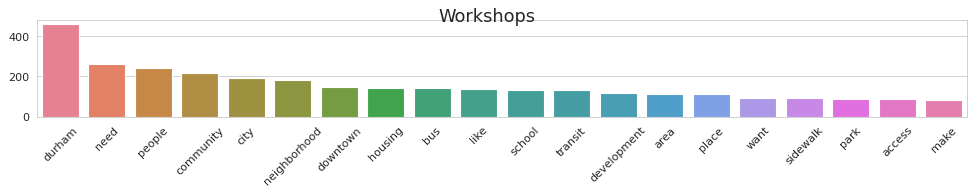

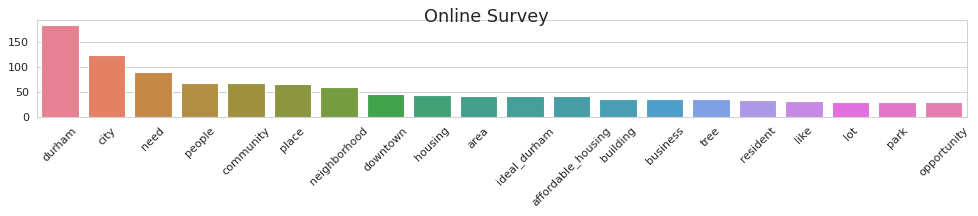

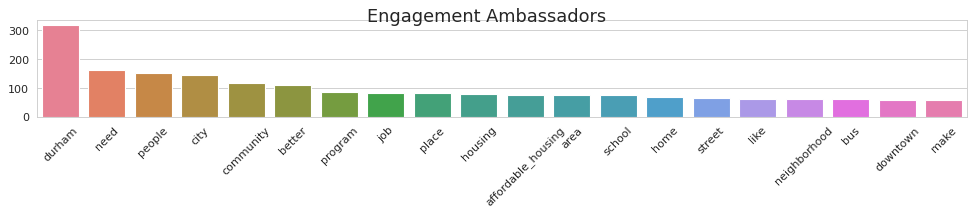

In [ ]:

# Generate three word list bar graphs and display
for i, (k, dataset_df) in enumerate(data_dict.items()):

    # LDA can only use raw term counts for LDA because it is a probabilistic graphical model
    # Initialise the count vectorizer with the English stop words (words to be removed)
    count_vectorizer = CountVectorizer(max_df=0.8, min_df=2, stop_words='english')
    #count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    
    # Fit and transform the processed titles
    my_documents  = list(dataset_df['text_processed'])
    count_data = count_vectorizer.fit_transform(my_documents)

    x_pos, counts, words = get_most_common_words(count_data, count_vectorizer)

    # Visualise most common words
    fig, axs = plt.subplots(1, 1, figsize=(15,1.6), dpi=80)
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=45) 
    fig.suptitle(sheet_names[i], fontsize=16)
    plt.show()

I see that "Sidewalk", "Transit", and "Development" only make the top 20 for the Workshops. "Green Space" was mentioned on the Online Survey. "Program", "Gentrification", "Job" only make the list for the Engagement Ambassador feedback. "Transit" is big for the Workshop group, while the other groups said "Transportation" or "Public Transportation".

In [ ]:
#@title Print Topics and Example Comments From Each Group

In [ ]:
# Generate sets of topics and sentences that contain those topics
for i, (k, dataset_df) in enumerate(data_dict.items()):
    
    # LDA can only use raw term counts for LDA because it is a probabilistic graphical model
    # Initialise the count vectorizer with the English stop words (words to be removed)
    count_vectorizer = CountVectorizer(max_df=0.80, min_df=2, stop_words='english')
    # Fit and transform the processed titles
    my_documents  = list(dataset_df['text_processed'])
    count_data = count_vectorizer.fit_transform(my_documents)
    tf_feature_names = count_vectorizer.get_feature_names()
    
    # Create and fit the LDA model
    lda_model = LatentDirichletAllocation(n_components=no_topics, n_jobs=-1, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(count_data)
    lda_W = lda_model.transform(count_data) # words
    lda_H = lda_model.components_ # topics
    
    # Print the topics found by the LDA model
    print(sheet_names[i] + ": Topics found via LDA")
    
    raw_comments  = list(dataset_df[dataset_df.columns[0]].astype(str))
    display_topics(lda_H, lda_W, tf_feature_names, raw_comments, no_words, no_top_comments)
    print("")

Workshops: Topics found via LDA
0: sidewalk park lot
    word of mouth communication & flyers & social media-clear & simple communication. homeless pass out fliers for a meal
    Must report back as changes occur in real time and get additional public input on acceptable alternatives. Early, often, iterative
    Word of mouth communication + fliers + social media - clear + simple communication 
    Ideal Durham - trash and waste from construction sites. Same way of dealing with it,  reclaimed - consider.
    Food. Farmer's markers Amazing restaurants. Chefs are mentors for upcoming chefs - welcoming community for food industry. 
    Technology of communicating and non technology way of communicating is important
    public parks, outdoor venues for impromptu gatherings and entertainment
    Add a shelter at every neighborhood and not a minimum post and bench
    multi use of space (ie more use of farmer market space ie lunching)
1: school housing level
    concern: given the track reco

# Word Cloud Comparison Between Groups

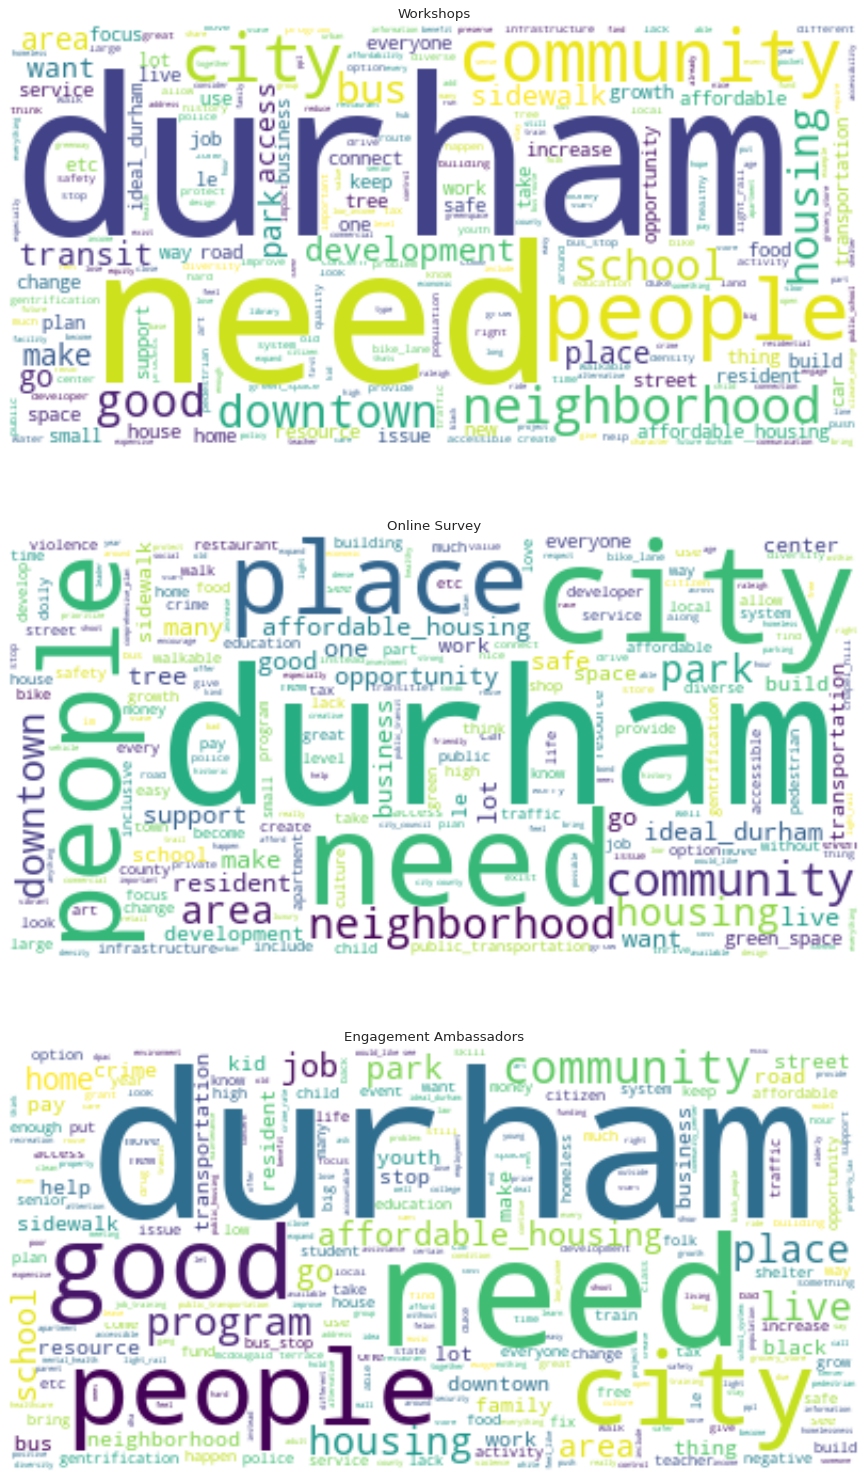

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(32,24), dpi=80)
# Generate three word clouds and display
for i, (k, v) in enumerate(data_dict.items()):
    (my_long_string, my_comment_list, my_cleaned_tokens_list) = prep(v)
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue').generate(my_long_string)
    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].set_title(sheet_names[i])
    axs[i].axis("off")
plt.show()

# Sentiment Analysis with NLTK

Here we try to classify whether each comment is positive or negative. It doesn't always work. But, we will train the classifier model on a dataset of messages from Twitter that were labeled by hand as Positive or Negative. After training, we will classify the comments from our groups, show some examples and compare the overall proportions.


In [ ]:
#@title Train Sentiment Model on Labeled Tweets
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')
text = twitter_samples.strings('tweets.20150430-223406.json')
tweet_tokens = twitter_samples.tokenized('positive_tweets.json')[0]
positive_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
positive_cleaned_tokens_list = []

# stopwords are words to remove like "an", "the", "and"
stop_words = stopwords.words('english')
for tokens in positive_tweet_tokens:
    positive_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

negative_tweet_tokens = twitter_samples.tokenized('negative_tweets.json')
negative_cleaned_tokens_list = []
for tokens in negative_tweet_tokens:
    negative_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

all_pos_words = get_all_words(positive_cleaned_tokens_list)

freq_dist_pos = FreqDist(all_pos_words)
#print("Most common words in positive word training set: ", freq_dist_pos.most_common(10))

positive_tokens_for_model = get_tweets_for_model(positive_cleaned_tokens_list)
negative_tokens_for_model = get_tweets_for_model(negative_cleaned_tokens_list)

positive_dataset = [(tweet_dict, "Positive")
                      for tweet_dict in positive_tokens_for_model]
negative_dataset = [(tweet_dict, "Negative")
                      for tweet_dict in negative_tokens_for_model]

dataset = positive_dataset + negative_dataset
random.shuffle(dataset)

train_data = dataset[:7000]
test_data = dataset[7000:]

classifier = NaiveBayesClassifier.train(train_data)
print("Accuracy is:", classify.accuracy(classifier, test_data))
#print(classifier.show_most_informative_features(10))

Accuracy is: 0.7383333333333333


In [ ]:
#@title Print Sentiment and Comments for Each Group

# Show example classified sentiments from each group
for i, (k, dataset_df) in enumerate(data_dict.items()):

    (my_long_string, comment_list, cleaned_tokens_list) = \
                                            prep(dataset_df)
    print(sheet_names[i] + ": Example Sentiments and Comments")

    for ii, custom_comment in enumerate(comment_list):
        if ii < data_rows_to_preview:
            custom_tokens = cleaned_tokens_list[ii]
            sentiment = classifier.classify(dict([token, True] for token in custom_tokens))
            print(" ", sentiment, "-", custom_comment)

Workshops: Example Sentiments and Comments
  Positive - word mouth_communication flier social medium clear simple communication
  Positive - communication find event like_this would nice 1 source everything there community oriented event find something good wonder why know this
  Positive - sign government building incorrect spanish
  Negative - technology communicating non technology way communicating important
  Positive - durham onecall perfect direct
  Positive - keeping service like durham one call place great customer_service
  Positive - accessible information conversation around program environment conversation go community instead making come
  Positive - transparent seeing comment access information
  Negative - information stay certain pocket want share information
  Negative - budgeting translate better communicate citizen know whats_going
Online Survey: Example Sentiments and Comments
  Negative - transparencybe transparent decision_process giving_public money private corp

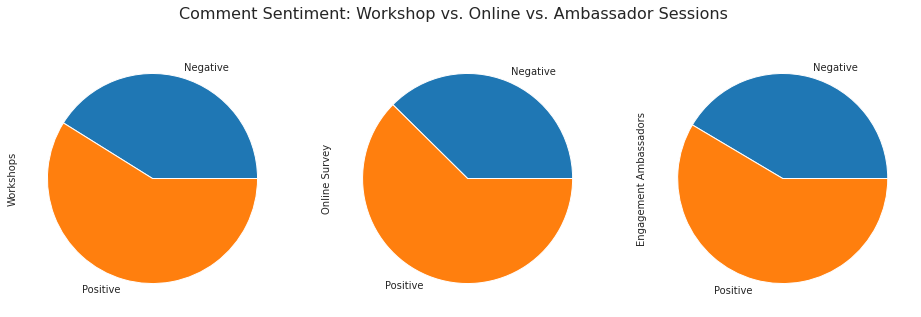

In [ ]:
#@title Show Three Pie Charts Comparing Overall Sentiment Counts
groups = list()
# Generate pie charts and display
for i, (k, v) in enumerate(data_dict.items()):
    sentiments = []

    (my_long_string, my_comment_list, my_cleaned_tokens_list) = prep(v)
    for ii, custom_comment in enumerate(my_comment_list):
        custom_tokens = my_cleaned_tokens_list[ii]
        sentiment = classifier.classify(dict([token, True] for token in custom_tokens))
        sentiments.append(sentiment)

    #@title Pie Chart Breakdown of Sentiment
    test = pd.Series(sentiments, name="Sentiment").astype("category")
    groups.append(test.groupby([test]).agg(len))

df = pd.concat([groups[0], groups[1], groups[2]], axis=1, keys=sheet_names)
axes = df.plot(kind='pie', subplots=True, figsize=(16,5))
for ax in axes:
    ax.set_aspect('equal')
    ax.get_legend().remove()
plt.suptitle('Comment Sentiment: Workshop vs. Online vs. Ambassador Sessions', fontsize=16);